In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *


torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')
TRAIN = Path('train512/')
TEST = Path('test512/')
TRAIN_AUG = Path('../aug/train/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
seg_aug = pd.read_csv('../aug/augment.csv', header=None)
seg_aug.columns = seg.columns
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

classes = [str(l) for l in range(28)]

In [3]:
df = pd.read_csv('aug_train_brian.csv'); len(df)

103940

In [4]:
# train_df = df.copy()
# train_df_orig=train_df.copy()    
# lows = [15,15,15,8,9,10,8,9,10,8,9,10,17,20,24,26,15,27,15,20,24,17,8,15,27,27,27]
# for i in lows:
#     target = str(i)
#     indicies = train_df_orig.loc[train_df_orig['Target'] == target].index
#     train_df = pd.concat([train_df,train_df_orig.loc[indicies]], ignore_index=True)
#     indicies = train_df_orig.loc[train_df_orig['Target'].str.startswith(target+" ")].index
#     train_df = pd.concat([train_df,train_df_orig.loc[indicies]], ignore_index=True)
#     indicies = train_df_orig.loc[train_df_orig['Target'].str.endswith(" "+target)].index
#     train_df = pd.concat([train_df,train_df_orig.loc[indicies]], ignore_index=True)
#     indicies = train_df_orig.loc[train_df_orig['Target'].str.contains(" "+target+" ")].index
#     train_df = pd.concat([train_df,train_df_orig.loc[indicies]], ignore_index=True)

In [5]:
def count_classes(df):
    out = np.zeros(28, dtype=int)
    for i in range(len(df)):
        idxs = [int(x) for x in df.Target.iloc[i].split()]
        out[idxs]+=1
    return out

In [6]:
count_classes(df)

array([40189,  2752,  9572,  3312,  4902,  5133,  3473,  7666,   945,   856,   788,  1922,  1741,  1137,  2598,   287,
        1156,   864,  1645,  3157,  1056, 11490,  1996,  9193,  1530, 33600,  1292,    55])

In [7]:
arch = models.resnet18

In [8]:
stats = ([0.08069, 0.05258, 0.05487], [0.13704,0.10145, 0.15313])
tfms = get_transforms(do_flip=True, flip_vert=True, 
                      max_lighting=0.1, max_warp=0.4)

In [9]:
def get_data(sz=64, bs=64, pct=0.2, sample=5000):
#     sz, pct, bs = 64, 0.2, 64
    src = (ImageItemList.from_df(df=df, path=PATH, folder=TRAIN_AUG, suffix='.png')
           .random_split_by_pct(pct)
           .label_from_df(sep=' ', classes=classes)
           .add_test([TEST/(f+'.png') for f in test_names]))
    data = (src.transform(tfms, size=sz)
            .databunch(bs=bs).normalize(stats))
    return data


In [10]:
def get_learner(data, focal=False, fp16=False):
    learn = create_cnn(data, arch, metrics=[accuracy_thresh, f1], 
               callback_fns=[partial(GradientClipping, clip=0.1), ShowGraph])
    if focal: learn.loss_func = FocalLoss()
    if fp16: learn.to_fp16();
#     learn.split((arch.layers[9],arch.layers[13]))  #Split for 444 model [11,20]
    return learn.mixup(stack_y=False)

# 256

In [13]:
data = get_data(256, 256, 0.1, sample=None)

In [12]:
learn = get_learner(data, focal=True, fp16=True)

In [14]:
# learn.model = nn.DataParallel(learn.model)

In [15]:
lr = 1e-2

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,1.319237,1.063394,0.955624,0.091586
2,1.112446,0.931107,0.959661,0.186991
3,1.028160,0.870205,0.962067,0.224027
4,0.973064,0.834725,0.962849,0.271862
5,0.942036,0.810959,0.963900,0.282427
6,0.923280,0.808427,0.963994,0.293818


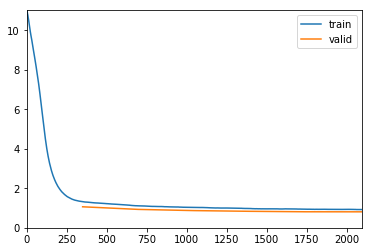

CPU times: user 7min 20s, sys: 2min 54s, total: 10min 15s
Wall time: 32min 8s


In [62]:
%time learn.fit_one_cycle(6, slice(lr))

In [16]:
learn.load('r18_final');

RuntimeError: Error(s) in loading state_dict for Sequential:
	Missing key(s) in state_dict: "0.0.weight", "0.1.weight", "0.1.bias", "0.1.running_mean", "0.1.running_var", "0.4.0.conv1.weight", "0.4.0.bn1.weight", "0.4.0.bn1.bias", "0.4.0.bn1.running_mean", "0.4.0.bn1.running_var", "0.4.0.conv2.weight", "0.4.0.bn2.weight", "0.4.0.bn2.bias", "0.4.0.bn2.running_mean", "0.4.0.bn2.running_var", "0.4.1.conv1.weight", "0.4.1.bn1.weight", "0.4.1.bn1.bias", "0.4.1.bn1.running_mean", "0.4.1.bn1.running_var", "0.4.1.conv2.weight", "0.4.1.bn2.weight", "0.4.1.bn2.bias", "0.4.1.bn2.running_mean", "0.4.1.bn2.running_var", "0.5.0.conv1.weight", "0.5.0.bn1.weight", "0.5.0.bn1.bias", "0.5.0.bn1.running_mean", "0.5.0.bn1.running_var", "0.5.0.conv2.weight", "0.5.0.bn2.weight", "0.5.0.bn2.bias", "0.5.0.bn2.running_mean", "0.5.0.bn2.running_var", "0.5.0.downsample.0.weight", "0.5.0.downsample.1.weight", "0.5.0.downsample.1.bias", "0.5.0.downsample.1.running_mean", "0.5.0.downsample.1.running_var", "0.5.1.conv1.weight", "0.5.1.bn1.weight", "0.5.1.bn1.bias", "0.5.1.bn1.running_mean", "0.5.1.bn1.running_var", "0.5.1.conv2.weight", "0.5.1.bn2.weight", "0.5.1.bn2.bias", "0.5.1.bn2.running_mean", "0.5.1.bn2.running_var", "0.6.0.conv1.weight", "0.6.0.bn1.weight", "0.6.0.bn1.bias", "0.6.0.bn1.running_mean", "0.6.0.bn1.running_var", "0.6.0.conv2.weight", "0.6.0.bn2.weight", "0.6.0.bn2.bias", "0.6.0.bn2.running_mean", "0.6.0.bn2.running_var", "0.6.0.downsample.0.weight", "0.6.0.downsample.1.weight", "0.6.0.downsample.1.bias", "0.6.0.downsample.1.running_mean", "0.6.0.downsample.1.running_var", "0.6.1.conv1.weight", "0.6.1.bn1.weight", "0.6.1.bn1.bias", "0.6.1.bn1.running_mean", "0.6.1.bn1.running_var", "0.6.1.conv2.weight", "0.6.1.bn2.weight", "0.6.1.bn2.bias", "0.6.1.bn2.running_mean", "0.6.1.bn2.running_var", "0.7.0.conv1.weight", "0.7.0.bn1.weight", "0.7.0.bn1.bias", "0.7.0.bn1.running_mean", "0.7.0.bn1.running_var", "0.7.0.conv2.weight", "0.7.0.bn2.weight", "0.7.0.bn2.bias", "0.7.0.bn2.running_mean", "0.7.0.bn2.running_var", "0.7.0.downsample.0.weight", "0.7.0.downsample.1.weight", "0.7.0.downsample.1.bias", "0.7.0.downsample.1.running_mean", "0.7.0.downsample.1.running_var", "0.7.1.conv1.weight", "0.7.1.bn1.weight", "0.7.1.bn1.bias", "0.7.1.bn1.running_mean", "0.7.1.bn1.running_var", "0.7.1.conv2.weight", "0.7.1.bn2.weight", "0.7.1.bn2.bias", "0.7.1.bn2.running_mean", "0.7.1.bn2.running_var", "1.2.weight", "1.2.bias", "1.2.running_mean", "1.2.running_var", "1.4.weight", "1.4.bias", "1.6.weight", "1.6.bias", "1.6.running_mean", "1.6.running_var", "1.8.weight", "1.8.bias". 
	Unexpected key(s) in state_dict: "module.0.0.weight", "module.0.1.weight", "module.0.1.bias", "module.0.1.running_mean", "module.0.1.running_var", "module.0.1.num_batches_tracked", "module.0.4.0.conv1.weight", "module.0.4.0.bn1.weight", "module.0.4.0.bn1.bias", "module.0.4.0.bn1.running_mean", "module.0.4.0.bn1.running_var", "module.0.4.0.bn1.num_batches_tracked", "module.0.4.0.conv2.weight", "module.0.4.0.bn2.weight", "module.0.4.0.bn2.bias", "module.0.4.0.bn2.running_mean", "module.0.4.0.bn2.running_var", "module.0.4.0.bn2.num_batches_tracked", "module.0.4.1.conv1.weight", "module.0.4.1.bn1.weight", "module.0.4.1.bn1.bias", "module.0.4.1.bn1.running_mean", "module.0.4.1.bn1.running_var", "module.0.4.1.bn1.num_batches_tracked", "module.0.4.1.conv2.weight", "module.0.4.1.bn2.weight", "module.0.4.1.bn2.bias", "module.0.4.1.bn2.running_mean", "module.0.4.1.bn2.running_var", "module.0.4.1.bn2.num_batches_tracked", "module.0.5.0.conv1.weight", "module.0.5.0.bn1.weight", "module.0.5.0.bn1.bias", "module.0.5.0.bn1.running_mean", "module.0.5.0.bn1.running_var", "module.0.5.0.bn1.num_batches_tracked", "module.0.5.0.conv2.weight", "module.0.5.0.bn2.weight", "module.0.5.0.bn2.bias", "module.0.5.0.bn2.running_mean", "module.0.5.0.bn2.running_var", "module.0.5.0.bn2.num_batches_tracked", "module.0.5.0.downsample.0.weight", "module.0.5.0.downsample.1.weight", "module.0.5.0.downsample.1.bias", "module.0.5.0.downsample.1.running_mean", "module.0.5.0.downsample.1.running_var", "module.0.5.0.downsample.1.num_batches_tracked", "module.0.5.1.conv1.weight", "module.0.5.1.bn1.weight", "module.0.5.1.bn1.bias", "module.0.5.1.bn1.running_mean", "module.0.5.1.bn1.running_var", "module.0.5.1.bn1.num_batches_tracked", "module.0.5.1.conv2.weight", "module.0.5.1.bn2.weight", "module.0.5.1.bn2.bias", "module.0.5.1.bn2.running_mean", "module.0.5.1.bn2.running_var", "module.0.5.1.bn2.num_batches_tracked", "module.0.6.0.conv1.weight", "module.0.6.0.bn1.weight", "module.0.6.0.bn1.bias", "module.0.6.0.bn1.running_mean", "module.0.6.0.bn1.running_var", "module.0.6.0.bn1.num_batches_tracked", "module.0.6.0.conv2.weight", "module.0.6.0.bn2.weight", "module.0.6.0.bn2.bias", "module.0.6.0.bn2.running_mean", "module.0.6.0.bn2.running_var", "module.0.6.0.bn2.num_batches_tracked", "module.0.6.0.downsample.0.weight", "module.0.6.0.downsample.1.weight", "module.0.6.0.downsample.1.bias", "module.0.6.0.downsample.1.running_mean", "module.0.6.0.downsample.1.running_var", "module.0.6.0.downsample.1.num_batches_tracked", "module.0.6.1.conv1.weight", "module.0.6.1.bn1.weight", "module.0.6.1.bn1.bias", "module.0.6.1.bn1.running_mean", "module.0.6.1.bn1.running_var", "module.0.6.1.bn1.num_batches_tracked", "module.0.6.1.conv2.weight", "module.0.6.1.bn2.weight", "module.0.6.1.bn2.bias", "module.0.6.1.bn2.running_mean", "module.0.6.1.bn2.running_var", "module.0.6.1.bn2.num_batches_tracked", "module.0.7.0.conv1.weight", "module.0.7.0.bn1.weight", "module.0.7.0.bn1.bias", "module.0.7.0.bn1.running_mean", "module.0.7.0.bn1.running_var", "module.0.7.0.bn1.num_batches_tracked", "module.0.7.0.conv2.weight", "module.0.7.0.bn2.weight", "module.0.7.0.bn2.bias", "module.0.7.0.bn2.running_mean", "module.0.7.0.bn2.running_var", "module.0.7.0.bn2.num_batches_tracked", "module.0.7.0.downsample.0.weight", "module.0.7.0.downsample.1.weight", "module.0.7.0.downsample.1.bias", "module.0.7.0.downsample.1.running_mean", "module.0.7.0.downsample.1.running_var", "module.0.7.0.downsample.1.num_batches_tracked", "module.0.7.1.conv1.weight", "module.0.7.1.bn1.weight", "module.0.7.1.bn1.bias", "module.0.7.1.bn1.running_mean", "module.0.7.1.bn1.running_var", "module.0.7.1.bn1.num_batches_tracked", "module.0.7.1.conv2.weight", "module.0.7.1.bn2.weight", "module.0.7.1.bn2.bias", "module.0.7.1.bn2.running_mean", "module.0.7.1.bn2.running_var", "module.0.7.1.bn2.num_batches_tracked", "module.1.2.weight", "module.1.2.bias", "module.1.2.running_mean", "module.1.2.running_var", "module.1.2.num_batches_tracked", "module.1.4.weight", "module.1.4.bias", "module.1.6.weight", "module.1.6.bias", "module.1.6.running_mean", "module.1.6.running_var", "module.1.6.num_batches_tracked", "module.1.8.weight", "module.1.8.bias". 

In [17]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.892324,0.951429,0.954802,0.288289
2,0.825756,0.784891,0.965273,0.271181
3,0.736576,0.819554,0.961901,0.383787
4,0.665784,0.689692,0.967959,0.448127
5,0.586907,0.553876,0.973863,0.551185
6,0.559643,0.533358,0.974785,0.561317


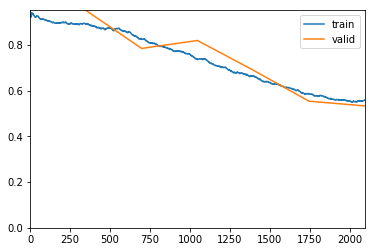

CPU times: user 11min 36s, sys: 4min 48s, total: 16min 25s
Wall time: 33min 34s


In [18]:
%time learn.fit_one_cycle(6, slice(lr/10, lr/3))

In [19]:
learn.save('r18_final');

In [20]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

# 512

In [21]:
data = get_data(512, 48, 0.01, sample=None)

In [22]:
learn = get_learner(data, focal=True, fp16=True)

In [23]:
state_dict = torch.load('models/r18_512_u.pth')

In [24]:
new_state_dict = OrderedDict()

In [25]:
for k, v in state_dict['model'].items():
#     print(k)
    name = k[7:] # remove `module.`
#     print(name)
    new_state_dict[name] = v

In [26]:
learn.model.load_state_dict(new_state_dict)

In [27]:
learn.freeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.435945,0.304188,0.984188,0.494433
2,0.422111,0.295554,0.984188,0.494994
3,0.415154,0.294628,0.984360,0.502219
4,0.400695,0.293784,0.984429,0.501693
5,0.401156,0.291907,0.984738,0.501333
6,0.410093,0.290366,0.984532,0.502389


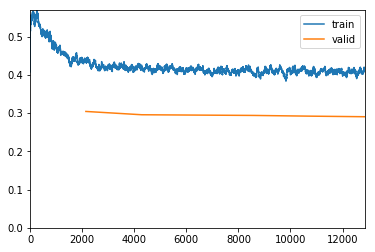

CPU times: user 1h 41min 53s, sys: 49min 36s, total: 2h 31min 29s
Wall time: 2h 32min 24s


In [28]:
%time learn.fit_one_cycle(6, slice(1e-3/3))

In [29]:
learn.save('r18_512_brian')

In [ ]:
learn.load('r18_512_brian');

In [ ]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,f1
1,0.429105,0.309662,0.982538,0.480143


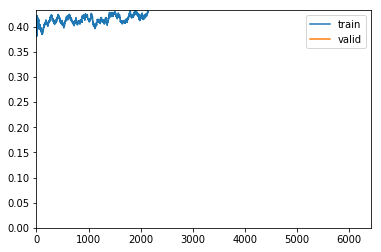

In [ ]:
lr = 1e-3
%time learn.fit_one_cycle(3, slice(lr/10, lr/5))

In [ ]:
learn.save('r18_512_brian_u')

In [ ]:
learn.data.test_dl.add_tfm(to_half)
p,t = learn.get_preds(ds_type=DatasetType.Test)

# Sub File

In [ ]:
preds = to_np(p.sigmoid())  #Check if we are using focal loss or BCE.
np.save('predsR18', preds)

In [67]:
threshold = 0.4 #ths
print(preds.shape)
classes = np.array(data.classes)
# classes = array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
#        '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [68]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_1834.csv', index=False)

In [69]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,2
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,5
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 5 25
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 25
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,


In [70]:
!kaggle competitions submit -c human-protein-atlas-image-classification -f "protein_1834.csv" -m "argmin"

100%|█████████████████████████████████████████| 465k/465k [00:01<00:00, 335kB/s]
Successfully submitted to Human Protein Atlas Image Classification

# Ensemble

In [41]:
p18 = np.load('predsR18.npy')

In [42]:
p34 = np.load('predsR34.npy')

In [43]:
preds = (p18 + p34)/2

In [48]:
p18.shape

(11702, 28)

In [65]:
preds = (p18,p34)/2

In [66]:
preds.shape

(11702, 28)